# Kaggle 1 - Classification d'événements météorologiques extrêmes

# I - Modèle de régression logistique multiclasses

In [8]:
#Importons les modules nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [9]:
# Google Colab
from google.colab import drive
drive.mount('/content/gdrive')
import sys
import os
import shutil
folder = "/content/gdrive/My Drive/Colab Notebooks/" #@param {type:"string"}


os.chdir(folder)

Mounted at /content/gdrive


## I.1 - Fonctions préliminaires

In [10]:
# functions to prepare features data & labels
#normalization
def normalize(X):
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    return (X-mu)/std
#add column of ones (bias term)
def add_bias(X):
    return np.c_[np.ones(X.shape[0]), X]

#one hot encoding
def Onehot(Y):
#    return pd.get_dummies(Y)
    nclasses = len(np.unique(Y))
    return np.eye(np.int32(Y.max()+1))[np.int32(Y)].reshape(-1,nclasses)

#Function to change time into Month, year, day
def time(df):

    #convert 'time' into Year|Month|day - train set
    df['time']= pd.to_datetime(df['time'], format='%Y%m%d')
    df['year'] = pd.DatetimeIndex(df['time']).year
    df['month'] = pd.DatetimeIndex(df['time']).month
    df['day'] = pd.DatetimeIndex(df['time']).day


#Function to split input data between features and labels
def features_labels(df,features = ['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'month'], labels = ['Label']):
    dx = df[features]
    dy = df[labels]
    return np.array(dx), np.array(dy)

#function to split dataset into train/validation, normalize and add bias + onehot encoding of labels
def train_val(dx, dy, split =0.8, rndseed = 42):
    n = dx.shape[0]
    n_train = np.int32(n * split)

    idx = list(range(n))
    #fix random seed to be able to reproduce results
    np.random.seed(rndseed)
    np.random.shuffle(idx)
    train_idx = idx[:n_train]
    val_idx = idx[n_train:]
    x_train = np.array(dx)[train_idx,:]
    y_train = np.array(dy)[train_idx].reshape(-1,)
    x_val = np.array(dx)[val_idx,:]
    y_val = np.array(dy)[val_idx].reshape(-1,)

    #add bias and normalize input data
    Xtrain = add_bias(normalize(x_train))
    Xval = add_bias(normalize(x_val))
    Xt = add_bias(normalize(dx))

    #dataY 1 hot encoding
    Yt= Onehot(dy)
    Ytrain = Onehot(y_train)
    Yval = Onehot(y_val)
    return Xtrain, Ytrain, Xval, Yval, Xt, Yt, y_train, y_val


#Function to measure accuracy of predictions by class:
# test accuracy by class
def results(pred, y):
    results = np.zeros((1,3))
    #accuracy of predictions by class
    results[0,0]=np.mean(y[y==0]==pred[y==0])
    results[0,1]=np.mean(y[y==1]==pred[y==1])
    results[0,2]=np.mean(y[y==2]==pred[y==2])
    return results

#function to print accuracy results for memo
def print_results(predtrain, y_train, acc_train, predval, y_val, acc_val):
# train/validation accuracy by class
  class_acc_train = results(predtrain, y_train)
  class_acc_val = results(predval,y_val)
  #printable array
  a = np.zeros((1,4))
  b = np.zeros((1,4))
  idxa = ['train accuracy']
  idxb = ['val accuracy']

  a[:,0] = acc_train
  a[:,1:] = class_acc_train
  b[:,0] = acc_val
  b[:,1:] = class_acc_val
  resa = pd.DataFrame(a, index = idxa)
  resb = pd.DataFrame(b, index = idxb)

  resa.columns = ['acc_train', 'acc_train_0','acc_train_1','acc_train_2']
  resb.columns = ['acc_val', 'acc_val_0','acc_val_1','acc_val_2']

  pd.options.display.float_format = '{:.2f}'.format
  print(resa *100)
  print('\n', resb*100)

#function to export test results to csv file
def export_output(pred, filename):
    index = [str(i) for i in range(1, len(pred)+1)]
    output = pd.DataFrame(pred,columns = ['label'], index = index)
    output.index.name = 'SNo'
#    print(output)
    output.to_csv(filename)


## I.2 - Implémentation de la régression logistique

In [11]:
#implement functions for LR
#softmax
def Softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis =1).reshape(-1,1)


In [12]:
#cost function with regularization
#X has dimensions n (# of training examples) * d (# of features) - theta is d * c (c = number of classes , i.e. 3)
# Y is n * c (i.e. one hot encoding of the array of training labels)
def CostFunction(theta,X,y, lreg):
    n=X.shape[0]
    g = Softmax(np.dot(X,theta)) # dimension: n* c
    J = -np.mean(np.sum(np.log(g) * y,axis=1),axis=0) + lreg/(2*n) *np.sum(np.square(theta))
    return J

#Gradient with regularization
def Gradient(theta,X,y, lreg):
    n = len(X)
    g = Softmax(np.dot(X,theta)) #dimensions n *c
    grad = 1/n *(np.dot(X.T,g-y) ) + lreg/n *theta #dimensions: d * c
    return grad

In [2]:
#Implement Gradient Descent
#Gradient Descent
def BatchGradientDescent(X,y,theta,alpha, Niter, threshold, lreg):
    J = np.zeros((Niter))
    for i in range(Niter):
        cost = CostFunction(theta, X, y, lreg)
        grad = Gradient(theta, X, y, lreg)
        if np.abs(grad).max() < threshold: break
        theta = theta - alpha * grad
        J[i] = cost
 #       print(cost.shape, grad.shape)
    return theta,J


In [23]:
# function to create mini-batches for mini-batch GD
def create_mini_batches(X, y, batch_size, rdnseed):
    mini_batches = []
    #recombine features and labels
    data = np.hstack((X, y))
    #fix la rdm seed pour pouvoir reproduire les résultats
    np.random.seed = rdnseed
    np.random.shuffle(data)
    #number of mini batches to go through the whole dataset
    n = data.shape[0] // batch_size
    i = 0

    for i in range(n + 1):
  # on sélection le mini-batch i:
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
  # on redivise le data entre features et labels, de taille mini_batch
        Xm = mini_batch[:, :-3]
        Ym = mini_batch[:, -3:]
    # on ajoute chaque mini-batch dans la liste mini_batches
        mini_batches.append((Xm, Ym))
# ajoute un dernier batch si  la taille des données d'entrée n'est pas divisible par la taille de chaque mini batch
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        Xm = mini_batch[:, :-3]
        Ym = mini_batch[:, -3:]
        mini_batches.append((Xm, Ym))
    return mini_batches

In [3]:
#Implement 1step of GD only (to be used in batchGD)
#Gradient Descent 1 step
def GradientDescent(X,y,theta,alpha, lreg):
    #m = len(X)
    J = 0
    cost = CostFunction(theta, X, y, lreg)
    grad = Gradient(theta, X, y, lreg)
    theta = theta - alpha * grad
    J = cost
 #       print(cost.shape, grad.shape)
    return theta,J, grad

In [47]:
#Mini - batch GDescent
def MiniBatchGD(X, y, theta, alpha, Niter, lreg, batch_size, threshold, print_iter, rndseed=4):
        i = 0
        J = np.zeros((Niter+1))
        #m= len(X)
        J[0] = CostFunction(initial_theta, X,y, lreg)
        while (i < Niter):
            mini_batches = create_mini_batches(X, y, batch_size, rndseed)
            c = 0 # moyenne de la fonction de cout sur les mini batches
            #idx = np.random.choice(X.shape[0], batch_size)
            for batch in mini_batches:
                X_batch, y_batch = batch
                #X[idx], y[idx]
                theta, cost, grad =  GradientDescent(X_batch, y_batch, theta, alpha,lreg)
                if np.abs(grad).max() < threshold: break
                c += cost
            if (i %10 == 0) & (print_iter):
                print(' Training Accuracy at {} iterations is {}'.format(i, np.mean(np.argmax(Softmax(np.dot(X,theta)), axis= 1)==np.argmax(y, axis=1))))

            J[i+1]=c/len(mini_batches)
            i +=1
        return theta, J


In [7]:
#predict classes based on input data X and LR model parameters theta
def predict(X,theta):
    pred = np.argmax(Softmax(np.dot(X,theta)), axis=1)
    return pred

#compute accuracy of predicted classes compared to actual labels y
def score(pred,y):
    return np.mean(pred == y)


## I.3 - Tests du modèle implémenté

### I.3.1 -  Importation des jeux de données d'entrainement et de test ClimateNet et Pré-processing

In [13]:
#Import Training and test set
#load data in pd
df = pd.read_csv('train.csv')
dt = pd.read_csv('test.csv')
print(list(df))


#convert 'time' into Year|Month|day - in train and test set
time(df)
time(dt)



['SNo', 'lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'time', 'Label']


In [14]:
# Split input data between features and Labels
features = ['lat', 'lon','TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT','month']
dx, dy  = features_labels(df,features = features, labels = 'Label')
dtest = dt[features]

print(dx.shape, dy.shape, dtest.shape)

(44760, 19) (44760,) (10320, 19)


In [15]:
#generate train and validation datasets

#split dataset into train/validation sets, normalize features and add bias + onehot encoding of labels
Xtrain, Ytrain, Xval, Yval, Xt, Yt, y_train, y_val =  train_val(dx, dy, split =0.8, rndseed = 42)


In [16]:
#preprocessing test data
Xtest = add_bias(normalize(dtest))

In [17]:
print(Xtrain.shape,Xval.shape,Xt.shape, Ytrain.shape, Yval.shape, Yt.shape, Xtest.shape)

(35808, 20) (8952, 20) (44760, 20) (35808, 3) (8952, 3) (44760, 3) (10320, 20)


### I.3.2 - Entrainement du modèle de régression logistique sur le jeu de données d'entrainement

In [48]:
# Initialize the parameters to zeros
initial_theta = np.zeros((Xtrain.shape[1],Ytrain.shape[1]))

#train LR on training data
theta, J = MiniBatchGD(Xtrain,Ytrain, initial_theta, alpha=0.005, Niter=100, lreg=0.,batch_size=100,threshold=0.00001,print_iter=True)

 Training Accuracy at 0 iterations is 0.7849642537980339
 Training Accuracy at 10 iterations is 0.8116342716711349
 Training Accuracy at 20 iterations is 0.8164376675603218
 Training Accuracy at 30 iterations is 0.8182529043789097
 Training Accuracy at 40 iterations is 0.8193141197497766
 Training Accuracy at 50 iterations is 0.8208780160857909
 Training Accuracy at 60 iterations is 0.8220230116175157
 Training Accuracy at 70 iterations is 0.8230283735478106
 Training Accuracy at 80 iterations is 0.8237823949955317
 Training Accuracy at 90 iterations is 0.8242012957998213


### I.3.3 - Résultats du modèle

In [38]:
#training error
pred_train = predict(Xtrain,theta)
#print(pred_train.shape)
accuracy_train = score(pred_train, y_train)

#validation error
pred_val = predict(Xval, theta)
#print(pred_val.shape)
accuracy_val = score(pred_val, y_val)

print_results(pred_train, y_train, accuracy_train, pred_val, y_val, accuracy_val)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      82.44        95.75        30.76        34.13

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    82.82      96.01      34.14      34.90


In [39]:
from numpy.core.arrayprint import printoptions
#compute predictions on test set
pred_test = predict(Xtest, theta)
#show % of predictions in each class
n, c  = np.unique(pred_test, return_counts = True)
np.set_printoptions(precision=2)
print('% of predictions of each class : ', c/len(pred_test) *100)

% of predictions of each class :  [90.68  1.21  8.11]


In [ ]:
# test accuracy on test dataset in kaggle
export_output(pred_test, 'results_LR_noreg.csv') #test accuracy 75.2

# II - Sensibilités testées

## II.1 - Comparaison Batch Gradient Descent et Mini-batch Gradient Descent

In [64]:
#re train on all train data
theta_gd, J_gd = BatchGradientDescent(Xtrain,Ytrain, initial_theta, alpha=0.005, Niter=200, threshold=0.0001,lreg=0.)

In [65]:
#training error
pred_train_gd = predict(Xtrain,theta_gd)
#print(pred_train.shape)
accuracy_train_gd = score(pred_train, y_train)

#validation error
pred_val_gd = predict(Xval, theta_gd)
#print(pred_val.shape)
accuracy_val_gd = score(pred_val_gd, y_val)

print_results(pred_train_gd, y_train, accuracy_train_gd, pred_val_gd, y_val, accuracy_val_gd)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      82.44        86.62        15.90        46.35

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    77.07      87.10      14.52      46.72


Text(0, 0.5, 'loss function')

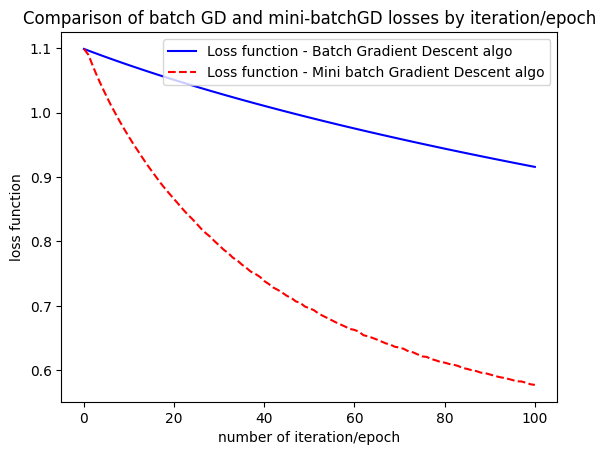

In [66]:
#Plot loss function by iteration


plt.plot(range(101),J_gd[:101], label = 'Loss function - Batch Gradient Descent algo', color = 'blue')
plt.plot(range(101),J, '--',label = 'Loss function - Mini batch Gradient Descent algo', color = 'red' )

plt.title('Comparison of batch GD and mini-batchGD losses by iteration/epoch')
plt.legend()
plt.xlabel('number of iteration/epoch')
plt.ylabel('loss function')


## II.2 - Sensibilité du modèle au choix de l'hyperparamètre alpha (learning rate)

In [54]:
#Sensitivity to learning rate alpha
alpha = [10,1,0.1,0.01,0.001,0.0001] #learning rates
losses= np.zeros((101,len(alpha)))
for i in range(len(alpha)):
    theta, J= MiniBatchGD(Xtrain,Ytrain, initial_theta, alpha=alpha[i], Niter=100, lreg=0.,batch_size=100,threshold=0.0001,print_iter=False)
    losses[:,i] = J

<ipython-input-12-d14f046d07d0>:7: RuntimeWarning: divide by zero encountered in log
  J = -np.mean(np.sum(np.log(g) * y,axis=1),axis=0) + lreg/(2*n) *np.sum(np.square(theta))
<ipython-input-12-d14f046d07d0>:7: RuntimeWarning: invalid value encountered in multiply
  J = -np.mean(np.sum(np.log(g) * y,axis=1),axis=0) + lreg/(2*n) *np.sum(np.square(theta))


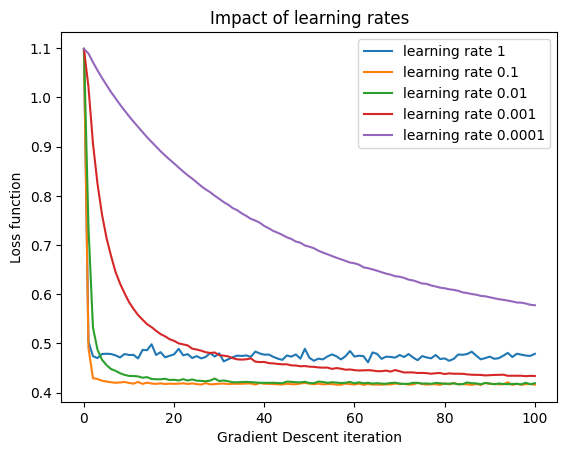

In [60]:
#plt.plot(range(101),losses[:,0], label ='learning rate 10')
plt.plot(range(101),losses[:,1], label ='learning rate 1')
plt.plot(range(101),losses[:,2], label ='learning rate 0.1')
plt.plot(range(101),losses[:,3], label ='learning rate 0.01')
plt.plot(range(101),losses[:,4], label ='learning rate 0.001')
plt.plot(range(101),losses[:,5], label ='learning rate 0.0001')

plt.title('Impact of learning rates')
plt.ylabel('Loss function')

plt.xlabel('Gradient Descent iteration')
plt.legend()

In [67]:
#compute predictions using best alpha =0.01
theta_gd, J_gd= BatchGradientDescent(Xtrain,Ytrain, initial_theta, alpha=0.01, Niter=2000, threshold=0.0001,lreg=0.)
#training error
pred_train_gd = predict(Xtrain,theta_gd)
#print(pred_train.shape)
accuracy_train = score(pred_train, y_train)

#validation error
pred_val_gd = predict(Xval, theta_gd)
#print(pred_val.shape)
accuracy_val = score(pred_val, y_val)

print_results(pred_train_gd, y_train, accuracy_train, pred_val_gd, y_val, accuracy_val)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      82.44        95.75        30.76        34.13

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    82.82      96.01      34.14      34.90


In [72]:
#compute predictions using best alpha =0.01
theta, J= MiniBatchGD(Xtrain,Ytrain, initial_theta, alpha=0.01, Niter=100, lreg=0.,batch_size=100,threshold=0.0001,print_iter=False,rndseed = 42)
#training error
pred_train = predict(Xtrain,theta)
#print(pred_train.shape)
accuracy_train = score(pred_train, y_train)

#validation error
pred_val = predict(Xval, theta)
#print(pred_val.shape)
accuracy_val = score(pred_val, y_val)

print_results(pred_train, y_train, accuracy_train, pred_val, y_val, accuracy_val)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      82.50        96.20        34.21        31.60

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    82.75      96.46      36.02      32.07


In [73]:
# compare mini-batch GD and batch GD predictions

print(np.mean(pred_train==pred_train_gd))
print(np.mean(pred_val==pred_val_gd))

classes, c_train = np.unique(y_train,return_counts=True)
classes, c_val = np.unique(y_val,return_counts=True)
classes, c_train_bgd = np.unique(pred_train,return_counts=True)
classes, c_val_bgd = np.unique(pred_val,return_counts=True)
classes, c_train_gd = np.unique(pred_train_gd,return_counts=True)
classes, c_val_gd = np.unique(pred_val_gd,return_counts=True)
print(c_train, c_train_bgd, c_train_gd)
print(c_val, c_val_bgd, c_val_gd)

0.9550100536193029
0.9594504021447721
[28155  1453  6200] [32248   656  2904] [33200   227  2381]
[7024  372 1556] [8063  169  720] [8266   64  622]


## II.3-  Test de l'implémentation de la régression logistique avec Scikit Learn

In [75]:
#test implementation of Logistic Regression with Scikitlearn
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty = None,fit_intercept = False,max_iter=2000, multi_class='multinomial',random_state=42).fit(Xtrain, y_train)


In [77]:
#Predictions
pred_clf =clf.predict(Xtrain)
pred_clf_val = clf.predict(Xval)
#accuracy train
acc_train = clf.score(Xtrain,y_train)
#accuracy validation
acc_val = clf.score(Xval,y_val)
print_results(pred_clf, y_train, acc_train, pred_clf_val, y_val, acc_val)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      82.15        95.06        36.48        34.21

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    82.53      95.29      37.10      35.80


In [78]:
# compare predictions on training data between my implementation and scikitlearn logistic regression
np.mean(pred_train==pred_clf)

0.9724642537980339

In [79]:
#compare predictions on validation data between my implementation and scikitlearn logistic regression
np.mean(pred_val_gd==pred_clf_val)

0.9531948168007149

In [80]:
# compare predictions on test dataset
pred_test= predict(Xtest,theta)
pred_clf_test = clf.predict(Xtest)

In [81]:
print(np.mean(pred_clf_test==pred_test))


0.9729651162790698


In [ ]:
# test accuracy on test dataset in kaggle
export_output(pred_clf_test, 'results_LRSKL_noreg.csv') # test accuracy = 75.7

## II.4- Impact de la régularisation

Analysons l'impact d'ajouter un terme de régularisation L2 dans la régression logistique, en faisant varier l'hyperparamètre de régularisation lreg, entre 0.01 et 200.

In [98]:
#add regularisation
#test implementation with Scikitlearn
reg = [0.1,0.2,1,2,5,10,20,100,200] #regularistion coeff
pred_train= np.zeros((Xtrain.shape[0],len(reg)))
pred_val= np.zeros((Xval.shape[0],len(reg)))
score_train = []
score_val = []
for i in range(len(reg)):
        clf = LogisticRegression(penalty = 'l2', C= reg[i], fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=42).fit(Xtrain, y_train)
        pred_train[:,i] = clf.predict(Xtrain)
        pred_val[:,i] = clf.predict(Xval)
        score_train.append(clf.score(Xtrain, y_train))
        score_val.append(clf.score(Xval, y_val))
        print('iteration # ', i)


iteration #  0
iteration #  1
iteration #  2
iteration #  3
iteration #  4
iteration #  5
iteration #  6
iteration #  7
iteration #  8


In [99]:
print(score_train)

[0.8249273905272565, 0.8238382484361036, 0.8219392314566577, 0.82171581769437, 0.8214644772117963, 0.8215203306523682, 0.8215761840929401, 0.8213527703306523, 0.8214365504915103]


In [100]:
print(score_val)

[0.8259606791778373, 0.8270777479892761, 0.8259606791778373, 0.8252904378909741, 0.8257372654155496, 0.8251787310098302, 0.8252904378909741, 0.8251787310098302, 0.8252904378909741]


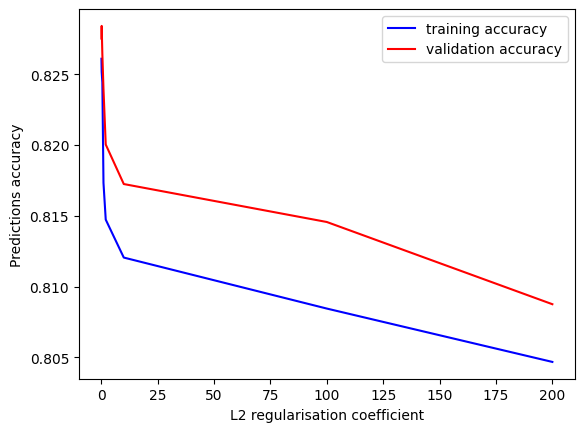

In [114]:

plt.plot(1/np.array(reg),score_train, color = 'blue', label ='training accuracy')
plt.plot(1/np.array(reg),score_val,color = 'red', label = 'validation accuracy')

plt.xlabel("L2 regularisation coefficient")
plt.ylabel("Predictions accuracy")
plt.legend()
plt.show()

In [91]:
#Test LR with regularisation L2, C=0.1
clf_reg = LogisticRegression(penalty = 'l2', C = 0.1,fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=4).fit(Xtrain, y_train)


In [92]:
#predictions
pred_clf_reg =clf_reg.predict(Xtrain)
predval_clf_reg = clf_reg.predict(Xval)
predtest_clf_reg = clf_reg.predict(Xtest)

In [93]:
#accuracy
#predictions
scoretrain_clf_reg =clf_reg.score(Xtrain, y_train)
scoreval_clf_reg = clf_reg.score(Xval, y_val)
print_results(pred_clf_reg, y_train, scoretrain_clf_reg, predval_clf_reg, y_val, scoreval_clf_reg)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      82.49        95.81        33.59        33.50

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    82.60      95.93      35.75      33.61


In [ ]:
#test accuracy on test dataset
export_output(predtest_clf_reg, 'results_LRSKL_regL2_0.1.csv') #test accuracy 75.4

In [102]:
#test regularisation avec mon implémentation de la régression logistique
reg = [0.005,0.01,0.1,0.5,1,2,5,10] #regularization coeff
pred_train= np.zeros((Xtrain.shape[0],len(reg)))
pred_val= np.zeros((Xval.shape[0],len(reg)))
score_train = []
score_val = []
for i in range(len(reg)):
        theta,J = MiniBatchGD(Xtrain,Ytrain, initial_theta, alpha=0.01, Niter=100, lreg=reg[i],batch_size=100,threshold=0.0001,print_iter=False, rndseed=42)
        pred_train[:,i] = predict(Xtrain,theta)
        pred_val[:,i] = predict(Xval,theta)
        score_train.append(score(pred_train[:,i], y_train))
        score_val.append(score(pred_val[:,i], y_val))
        print('iteration # ', i)

iteration #  0
iteration #  1
iteration #  2
iteration #  3
iteration #  4
iteration #  5
iteration #  6
iteration #  7


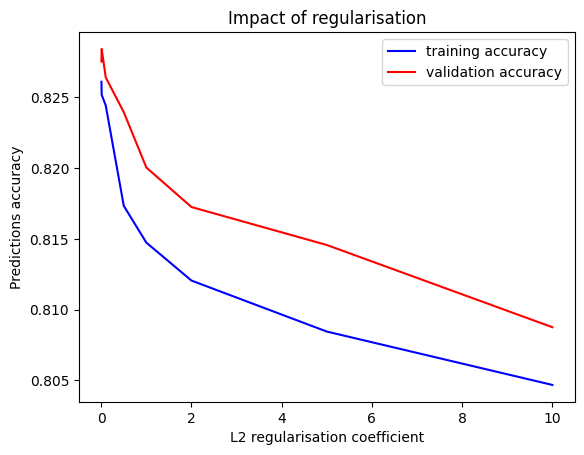

In [103]:
plt.plot(np.array(reg),score_train, color = 'blue', label ='training accuracy')
plt.plot(np.array(reg),score_val,color = 'red', label = 'validation accuracy')

plt.xlabel("L2 regularisation coefficient")
plt.ylabel("Predictions accuracy")
plt.legend()
plt.title('Impact of regularisation')
plt.show()

In [104]:
score_train

[0.8261003127792672,
 0.8251787310098302,
 0.824424709562109,
 0.8173313226094727,
 0.8147341376228776,
 0.8120531724754245,
 0.8084506255585344,
 0.8046805183199285]

In [105]:
score_val

[0.8275245755138516,
 0.8284182305630027,
 0.8264075067024129,
 0.8239499553172476,
 0.8200402144772118,
 0.8172475424486149,
 0.8145665773011618,
 0.80875781948168]

## II.5-  Sensibilité du modèle de classification aux features sélectionnés

On va tester l'impact d'utiliser uniquement les features les plus pertinents pour la prévision des CT et RA (features mentionnés dans l'article ClimateNEt).

In [ ]:
# Use only the 4 features highlighted in CLimateNet paper: TMQ, U850, V850, PRECT for training the LR model

# analyse features by label
features = ['lat', 'lon', 'TMQ', 'U850', 'V850', 'PRECT','month']
dx = df[features]
dy = df['Label']
dtest = dt[features]

print(dx.shape, dy.shape)

(44760, 7) (44760,)


In [ ]:
#split dataset into train/validation sets, normalize features and add bias + onehot encoding of labels
Xtrain, Ytrain, Xval, Yval, Xt, Yt, y_train, y_val =  train_val(dx, dy, split =0.8, rndseed = 42)
#Add bias and normalize test data
Xtest = add_bias(normalize(dtest))
# Initialize the fitting parameters
initial_theta = np.zeros((Xtrain.shape[1],Ytrain.shape[1]))
print(Xtrain.shape, Xval.shape, Xtest.shape)

(35808, 8) (8952, 8) (10320, 8)


In [ ]:
#LR without regularisation
clf = LogisticRegression(penalty = None,fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=42).fit(Xtrain, y_train)


In [ ]:
#predictions
pred_clf=clf.predict(Xtrain)
predval_clf = clf.predict(Xval)
predtest_clf = clf.predict(Xtest)

In [ ]:
utrain, ctrain = np.unique(pred_clf, return_counts = True)
uval, cval = np.unique(predval_clf, return_counts = True)
utest, ctest = np.unique(predtest_clf, return_counts = True)
print('accuracy class 0: ', np.mean(y_val[y_val==0]==predval_clf[y_val==0]))
print('accuracy class 1: ', np.mean(y_val[y_val==1]==predval_clf[y_val==1]))
print('accuracy class 2: ', np.mean(y_val[y_val==2]==predval_clf[y_val==2]))
print(ctrain, cval, ctest)

accuracy class 0:  0.9499221955014854
accuracy class 1:  0.3324175824175824
accuracy class 2:  0.347597103357472
[31550   814  3444] [7933  184  835] [9404  130  786]


In [ ]:
#accuracy of predictions
scoretrain_clf=clf.score(Xtrain, y_train)
scoreval_clf = clf.score(Xval, y_val)
print_results(pred_clf, y_train, scoretrain_clf, predval_clf, y_val,scoreval_clf)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      81.39        96.21        13.70        29.97

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    81.89      96.33      19.09      31.75


In [ ]:
# test accuracy of predictions on test dataset
export_output(predtest_clf, 'results_LRSKL_noreg_4features.csv') # test accuracy =

## II.6 - Sensibilité à la pondération des classes

Testons l'impact d'ajouter une pondéreration aux différentes classes pour compenser le déséquilibre d'observations entre les classes.

In [ ]:
# réimportons les données avec toutes les features
# Split input data between features and Labels
features = ['lat', 'lon','TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT','month']
dx, dy  = features_labels(df,features = features, labels = 'Label')
dtest = dt[features]

print(dx.shape, dy.shape, dtest.shape)

(44760, 19) (44760,) (10320, 19)


In [ ]:
#split dataset into train/validation sets, normalize features and add bias + onehot encoding of labels
Xtrain, Ytrain, Xval, Yval, Xt, Yt, y_train, y_val =  train_val(dx, dy, split =0.8, rndseed = 42)
#Add bias and normalize test data
Xtest = add_bias(normalize(dtest))
# Initialize the fitting parameters
initial_theta = np.zeros((Xtrain.shape[1],Ytrain.shape[1]))
print(Xtrain.shape, Xval.shape, Xtest.shape)

(35808, 20) (8952, 20) (10320, 20)


In [ ]:
#On va tester différents poids et retenir celui qui donne le meilleur compromis entre précision globale et précision au niveau de chaque classe
weights = ['balanced', {0:1,1:16,2:4},{0:1,1:8,2:2},{0:1,1:6,2:3},{0:1,1:5,2:2.5},{0:1,1:5,2:2},{0:1,1:2.5,2:1.25},{0:1,1:2.5,2:2}, {0:1,1:2,2:2}]
n = len(weights)
res = np.zeros((n,6)) #store accuracy by class and accuracy on train and val sets
for i in range(n):
    clf = LogisticRegression(penalty = None, class_weight = weights[i],fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=4).fit(Xtrain, y_train)
    predtrain = clf.predict(Xtrain)
    predval = clf.predict(Xval)
    resval = results(predval, y_val)
#    res[i, 0] = weights[i]
    res[i, 1] = resval[0,0]
    res[i, 2] = resval[0,1]
    res[i, 3] = resval[0,2]
    res[i, 4] = clf.score(Xtrain, y_train)
    res[i, 5] = clf.score(Xval, y_val)
    print(weights[i])
print(res)

balanced
{0: 1, 1: 16, 2: 4}
{0: 1, 1: 8, 2: 2}
{0: 1, 1: 6, 2: 3}
{0: 1, 1: 5, 2: 2.5}
{0: 1, 1: 5, 2: 2}
{0: 1, 1: 2.5, 2: 1.25}
{0: 1, 1: 2.5, 2: 2}
{0: 1, 1: 2, 2: 2}
[[0.         0.5827164  0.91129032 0.84447301 0.63812556 0.64186774]
 [0.         0.6328303  0.89247312 0.81298201 0.67174933 0.67493298]
 [0.         0.8143508  0.79301075 0.61118252 0.77502234 0.77815013]
 [0.         0.76950456 0.71505376 0.71658098 0.75835009 0.7580429 ]
 [0.         0.81050683 0.67204301 0.67030848 0.77750782 0.78038427]
 [0.         0.83798405 0.66935484 0.60989717 0.78973972 0.79133155]
 [0.         0.91856492 0.54569892 0.43251928 0.8169962  0.81858803]
 [0.         0.86944761 0.54569892 0.60861183 0.80909294 0.81065684]
 [0.         0.87443052 0.52688172 0.60861183 0.81252793 0.81378463]]


In [ ]:
#impression pour memo
index = weights
a = np.zeros_like(res[:,1:])
a[:,0] = res[:,4]
a[:,1] = res[:,5]
a[:,2] = res[:,1]
a[:,3] = res[:,2]
a[:,4] = res[:,3]
pres = pd.DataFrame(a, index = index)

pres.columns = ['acc_train', 'acc_val','acc_val_0', 'acc_val_1', 'acc_val_2']
pd.options.display.float_format = '{:.2f}'.format
print(pres)

                         acc_train  acc_val  acc_val_0  acc_val_1  acc_val_2
balanced                      0.64     0.64       0.58       0.91       0.84
{0: 1, 1: 16, 2: 4}           0.67     0.67       0.63       0.89       0.81
{0: 1, 1: 8, 2: 2}            0.77     0.78       0.81       0.79       0.61
{0: 1, 1: 6, 2: 3}            0.76     0.76       0.77       0.72       0.72
{0: 1, 1: 5, 2: 2.5}          0.78     0.78       0.81       0.67       0.67
{0: 1, 1: 5, 2: 2}            0.79     0.79       0.84       0.67       0.61
{0: 1, 1: 2.5, 2: 1.25}       0.82     0.82       0.92       0.55       0.43
{0: 1, 1: 2.5, 2: 2}          0.81     0.81       0.87       0.55       0.61
{0: 1, 1: 2, 2: 2}            0.81     0.81       0.87       0.53       0.61


In [ ]:
#test weights 1: 6, 2: 3
clf = LogisticRegression(penalty = 'none', class_weight = {0: 1, 1: 2.5, 2:2},fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=4).fit(Xt, dy)
predtrain = clf.predict(Xtrain)
predval = clf.predict(Xval)
resval = results(predval, y_val)
print(clf.score(Xtrain, y_train),clf.score(Xval, y_val),clf.score(Xt, dy), resval)

0.8085344057193923 0.8095397676496873 0.8090035746201966 [[0.86873576 0.53763441 0.60732648]]


Les poids 0:1, 1: 2.5, 2: 2 semblent donner le meilleur compromis entre la précision sur les données de validation, et la précision de chaque classe.

In [ ]:
# Testons la régression logistique avec ces poids
clf = LogisticRegression(penalty = None, class_weight = {0:1,1:2.5,2:2}, fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=4).fit(Xtrain, y_train)


In [ ]:
#predictions
pred_clf=clf.predict(Xtrain)
predval_clf = clf.predict(Xval)
predtest_clf = clf.predict(Xtest)

In [ ]:
#accuracy of predictions
scoretrain_clf=clf.score(Xtrain, y_train)
scoreval_clf = clf.score(Xval, y_val)
print_results(pred_clf, y_train, scoretrain_clf, predval_clf, y_val,scoreval_clf)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      80.91        86.80        53.13        60.68

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    81.07      86.94      54.57      60.86


In [ ]:
# test accuracy of predictions on test dataset
export_output(predtest_clf, 'results_LRSKL_noreg_weights2.5_2.csv') #precision test = 77.6

## II.7- Impact des données redondantes

Test 1 - Enlever toutes les lignes avec duplicates

In [ ]:
#test duplicates
features = ['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'time']
duplicates = df.duplicated(features, keep=False) #keep = False permet de considérer toutes les lignes avec des données redondantes
dclean = df[~duplicates] # dataframe original sans les lignes duplicates
print(dclean.shape)

(10320, 21)


In [ ]:
# compter le nombre d'observations par classe dans les données initiales, et sans les duplicates
u, c = np.unique(df['Label'], return_counts = True)
ud, cd = np.unique(dclean['Label'], return_counts = True)
print(c, cd)

[35179  1825  7756] [8334  309 1677]


In [ ]:
#compte le nombre de duplicates avec des labels differents
dupli = df[duplicates]
features_Lab = ['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'time','Label']
dupli_lab = df[df.duplicated(features_Lab, keep=False)]
print(dupli.shape, dupli_lab.shape)

(34440, 21) (31229, 21)


On va entrainer le modèle de régression logistique sur le jeu de données sans doublons.

In [ ]:
#data pre-processing
#time(dclean)
dx, dy = features_labels(dclean)
print(dx.shape, dy.shape)
Xtrain, Ytrain, Xval, Yval, Xt, Yt, y_train, y_val = train_val(dx,dy)
print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, Xt.shape, Yt.shape, y_train.shape, y_val.shape )
#print(y_val)

(10320, 19) (10320, 1)
(8256, 20) (8256, 3) (2064, 20) (2064, 3) (10320, 20) (10320, 3) (8256,) (2064,)


In [ ]:
#LR without regularisation
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty = None,fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=4).fit(Xtrain, y_train)


In [ ]:
# predictions
predtrain = clf.predict(Xtrain)
predval = clf.predict(Xval)
# train/val accuracy ant print results by class
acc_train = clf.score(Xtrain, y_train)
acc_val = clf.score(Xval, y_val)
print_results(predtrain, y_train, acc_train, predval, y_val, acc_val)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy       0.87         0.97         0.51         0.46

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy     0.85       0.96       0.39       0.42


Les résultats sur l'ensemble de validation semblent meilleurs que ceux obtenus en entrainant le modèle sur le jeu de données complet.

In [ ]:
# testons les résultats sur l'ensemble de test
predtest_clf = clf.predict(Xtest)

utest, ctest = np.unique(predtest_clf, return_counts = True)
print(ctest)

[9169  237  914]


In [ ]:
export_output(predtest_clf,'results_LRSKL_noreg_removeduplicatesFalse.csv') # test precision = 74.8

In [ ]:
# with class imbalance
clf = LogisticRegression(penalty = None, class_weight = {0:1,1:2.5,2:2}, fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=4).fit(Xtrain, y_train)


In [ ]:
#predictions
predtrain = clf.predict(Xtrain)
predval = clf.predict(Xval)
# train/val accuracy ant print results by class
acc_train = clf.score(Xtrain, y_train)
acc_val = clf.score(Xval, y_val)
print_results(predtrain, y_train, acc_train, predval, y_val, acc_val)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy       0.85         0.90         0.62         0.64

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy     0.84       0.89       0.53       0.61


In [ ]:
predtest_clf = clf.predict(Xtest)

utest, ctest = np.unique(predtest_clf, return_counts = True)
print(ctest)

[8187  453 1680]


In [ ]:
export_output(predtest_clf,'results_LRSKL_weights2.5_2_noreg_withoutdupli.csv') #not tested

test2: Garder une seule ligne par duplicate, en conservant pour chaque doublon le label majoritaire parmi les lignes dupliquées.

In [ ]:
#reload train data in pd
df = pd.read_csv('train.csv')

duplicates = df.duplicated(['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'time'], keep = False)
dfY = Onehot(np.array(df['Label'])) # labels sous forme one hot encoding
#print(dfY[duplicates].shape)
dfd = df[duplicates] # dataframe avec juste les lignes dédoublées
#dataframe avec juste les features
dxd = dfd[['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'time']]
#créons une variable idx qui sera la somme de toutes les variables features, et permettra d'identifier les doublons
idx = np.sum(dxd, axis=1)
dfd['idx'] = idx
# définissons les champs class0, class1, class2 correspondant aux labels encodés onehot.
dfd['class0'] = dfY[duplicates] [:,0]
dfd['class1'] = dfY[duplicates] [:,1]
dfd['class2'] = dfY[duplicates] [:,2]

#print(dfd.shape)
#on commence par grouper les données selon le champ 'idx', en faisant la somme (seules les sommes des variables class0, class1, class2 nous intéressent)
dupli = dfd.groupby(['idx']).sum()
#on récupère le label majoritaire pour chaque instance de ligne dupliquée
dupli['Label'] = np.argmax(np.array(dupli[['class0','class1','class2']]), axis = 1)
#on groupe ensuite les lignes selon le champ 'idx', en prenant cette fois le max (pour toutes les lignes doublons, cela revient à prendre la valeur des variables puisqu'elles sont toutes identiques)
dupli1 = dfd.groupby(['idx']).max()
# on remplace le Label par le label majoritaire
dupli1['Label'] = dupli['Label']
#print(dupli1)

#On va concaténer le dataframe original sans aucun duplicates, et le dataframe de duplicates dupli1 créé
d1 = df[~duplicates]
d2 = dupli1[['SNo','lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'time', 'Label']]
d3= pd.concat([d1,d2])
print(d3.shape)

(21120, 21)


<ipython-input-61-8e3222c079bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfd['idx'] = idx
<ipython-input-61-8e3222c079bf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfd['class0'] = dfY[duplicates] [:,0]
<ipython-input-61-8e3222c079bf>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

Testons les modèle de régression logistique sur le jeu de données d3

In [ ]:
#data pre-processing
time(d3)
dx, dy = features_labels(d3)
print(dx.shape, dy.shape)
Xtrain, Ytrain, Xval, Yval, Xt, Yt, y_train, y_val = train_val(dx,dy)
print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, Xt.shape, Yt.shape, y_train.shape, y_val.shape )
#print(y_val)

(21120, 19) (21120, 1)
(16896, 20) (16896, 3) (4224, 20) (4224, 3) (21120, 20) (21120, 3) (16896,) (4224,)


In [ ]:
print(dy.shape)

(21120, 1)


In [ ]:
# Testons les modèle de régression logistique sur les données sans duplicates
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty = 'none', fit_intercept = False,max_iter=1000, multi_class='multinomial',random_state=4).fit(Xtrain, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# predictions
predtrain = clf.predict(Xtrain)
predval = clf.predict(Xval)
# train/val accuracy ant print results by class
acc_train = clf.score(Xtrain, y_train)
acc_val = clf.score(Xval, y_val)
print_results(predtrain, y_train, acc_train, predval, y_val, acc_val)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy       0.86         0.97         0.47         0.32

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy     0.86       0.96       0.48       0.31


In [ ]:
#test predictions on initial dataset (with duplicates)
predX_clf = clf.predict(add_bias(normalize(df[features])))

uX, cX = np.unique(predX_clf, return_counts = True)
print('accuracy class 0: ', np.mean(dy[dy==0]==predX_clf[dy==0]))
print('accuracy class 1: ', np.mean(dy[dy==1]==predX_clf[dy==1]))
print('accuracy class 2: ', np.mean(dy[dy==2]==predX_clf[dy==2]))

print(cX)

accuracy class 0:  0.8709741607208846
accuracy class 1:  0.4449315068493151
accuracy class 2:  0.5644662197008767
[34863  1530  8367]


In [ ]:

#predictions on test dataset
predtest = model.predict(Xtest)
u, c = np.unique(predtest, return_counts =True)
print(c)

In [ ]:
export_output(predtest_clf,'results_RemoveDuplicates_MostFreq2.csv') # test precision = 74.8

In [ ]:
# Testons le modèle de régression logistique sur les données ponderees par classe
clf = LogisticRegression(penalty = None, class_weight = {0:1,1:2.5,2:2.5}, fit_intercept = False,max_iter=10000, multi_class='multinomial',random_state=42).fit(Xtrain, y_train)

In [ ]:
# predictions
predtrain = clf.predict(Xtrain)
predval = clf.predict(Xval)
# train/val accuracy ant print results by class
acc_train = clf.score(Xtrain, y_train)
acc_val = clf.score(Xval, y_val)
print_results(predtrain, y_train, acc_train, predval, y_val, acc_val)


                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy       0.85         0.89         0.61         0.64

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy     0.85       0.89       0.61       0.66


In [ ]:
#predictions on test dataset
predtest = clf.predict(Xtest)
# precision not tested on Kaggle

# III - Autres modèles testés

## III.1 - Réseau de neurones à une couche cachée

In [ ]:
from sklearn.neural_network import MLPClassifier


Testons d'abord l'impact du nombre de neurons dans la couche cachée sur la précision du modèle.

In [ ]:
#test impact of NN structure - 1 layer
res = np.zeros((15,8))
for i in range(15):
    model = MLPClassifier(solver='adam', alpha=0.1, hidden_layer_sizes=(i+1), max_iter = 10000, random_state=42)
    model.fit(Xtrain, y_train)
    predtrain = model.predict(Xtrain)
    predval=model.predict(Xval)
    acc_train = np.mean(predtrain==y_train)
    acc_val = np.mean(predval==y_val)
    restrain = results(predtrain, y_train)
    resval = results(predval, y_val)
    res[i,0] = acc_train
    res[i,1:4] = restrain
    res[i,4]=acc_val
    res[i,5:] = resval

Text(0.5, 1.0, 'Impact of NN structure - 1 hidden layer')

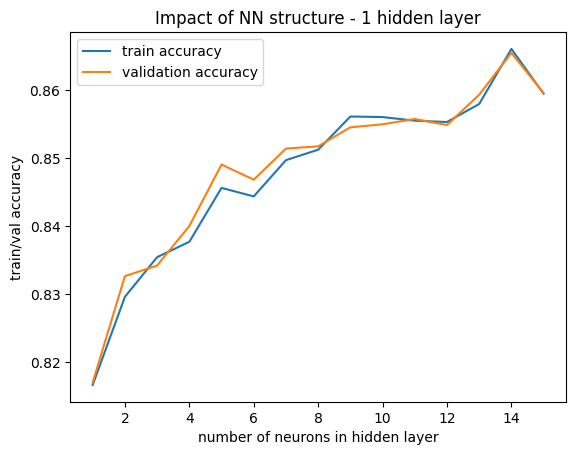

In [ ]:
# graph showing val accuracy, train accuracy based on # of hidden neurons
idx = np.arange(15)+1
plt.plot(idx, res[:,0].T, label = 'train accuracy')
plt.plot(idx, res[:,4].T, label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 1 hidden layer')


In [ ]:
#test du modele NN a une couche cachée avec 10 neurones

model = MLPClassifier(solver='adam', alpha=0.1, hidden_layer_sizes=(10), max_iter = 10000, random_state=42)
model.fit(Xtrain, y_train)
predtrain = model.predict(Xtrain)
accuracytrain=np.mean(y_train==predtrain)
#print("Accuracy of the training dataset : ", accuracytrain )
predval=model.predict(Xval)
accuracyval=np.mean(y_val==predval)
#print("Accuracy of the validation dataset : ", accuracyval )
print_results(predtrain, y_train, accuracytrain, predval, y_val, accuracyval)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      85.61        94.41        45.63        55.00

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    85.50      94.11      48.12      55.59


## III.2 Réseau de neurones à 2 couches cachées

Testons d'abord l'impact du nombre de neurones dans les 2 couches cachées sur la précision des prédictions (entrainement vs validation)

In [ ]:
#test impact of NN structure - 2layers
restrain = np.zeros((10,5))
resval = np.zeros((10,5))

for i in range(10):
    for j in range(5):
        model = MLPClassifier(solver='adam', alpha=0.1, hidden_layer_sizes=(i+1, j+1), max_iter = 10000, random_state=42)
        model.fit(Xtrain, y_train)
        predtrain = model.predict(Xtrain)
        predval=model.predict(Xval)
        acc_train = np.mean(predtrain==y_train)
        acc_val = np.mean(predval==y_val)
        restrain[i,j] = acc_train
        resval[i,j]=acc_val


Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers')

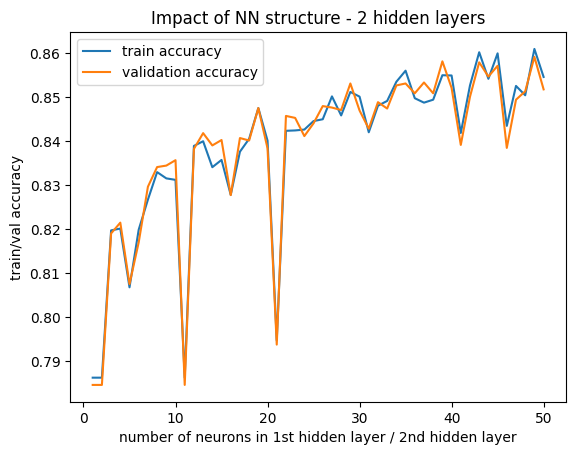

In [ ]:
# graph showing val accuracy, train accuracy based on # of hidden neurons

idx = np.arange(50)+1
plt.plot(idx, restrain.flatten(), label = 'train accuracy')
plt.plot(idx, resval.flatten(), label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 1st hidden layer / 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers')

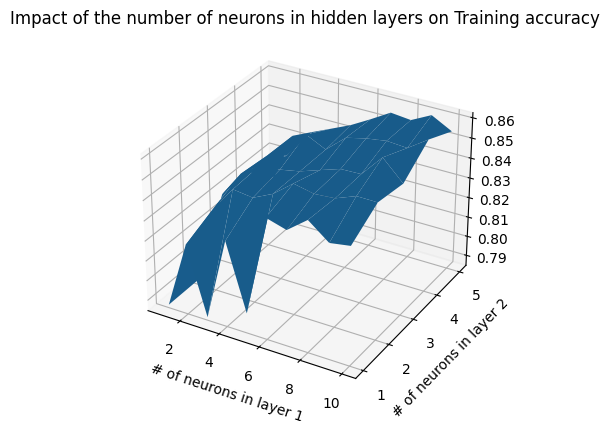

In [ ]:

#3D graph of training accuracy versus number of neurons in 1st and 2nd layers
idx = np.arange(10)+1
idy = np.arange(5)+1
X, Y = np.meshgrid(idx, idy)
ax = plt.figure().add_subplot(projection='3d')

# Plot the surface with face colors taken from the array we made.
surf = ax.plot_surface(X, Y, restrain.T,  linewidth=0)

plt.xlabel('# of neurons in layer 1')
plt.ylabel('# of neurons in layer 2')

plt.title('Impact of the number of neurons in hidden layers on Training accuracy')
plt.show()


Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 1 neuron')

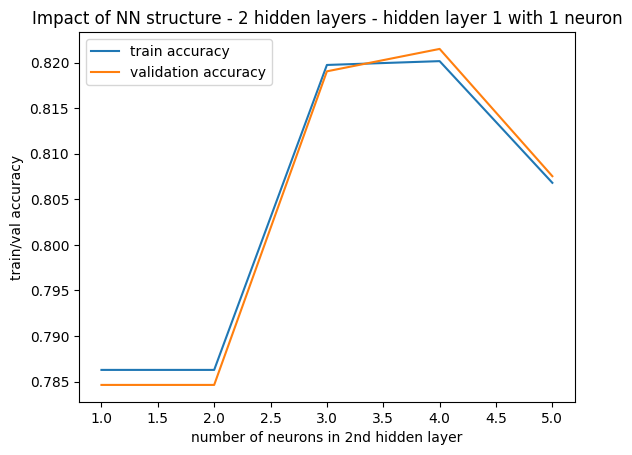

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[0,:], label = 'train accuracy')
plt.plot(idx, resval[0,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 1 neuron')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 2 neurons')

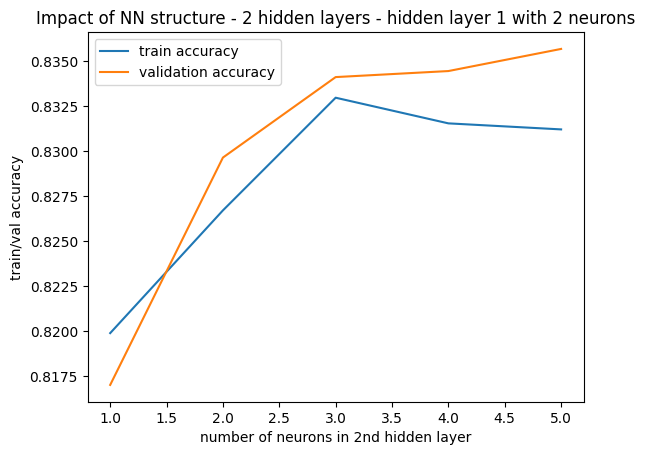

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[1,:], label = 'train accuracy')
plt.plot(idx, resval[1,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 2 neurons')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 3 neurons')

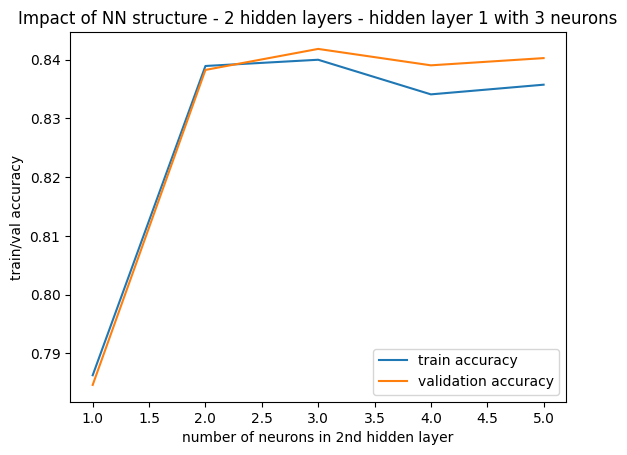

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[2,:], label = 'train accuracy')
plt.plot(idx, resval[2,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 3 neurons')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 4 neurons')

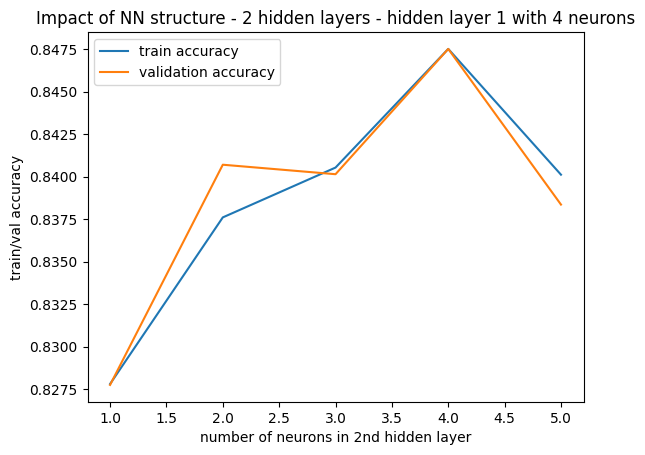

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[3,:], label = 'train accuracy')
plt.plot(idx, resval[3,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 4 neurons')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 5 neurons')

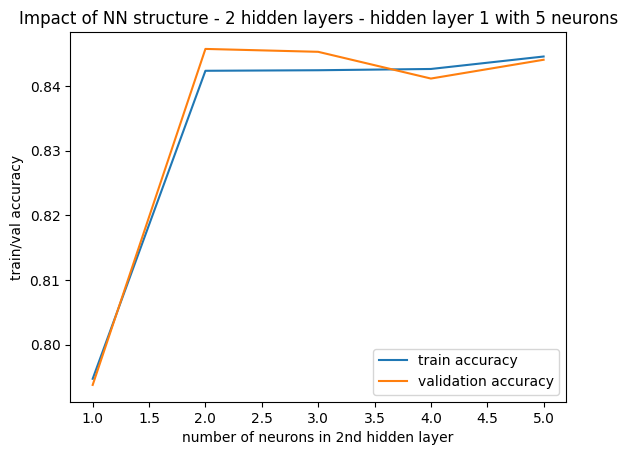

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[4,:], label = 'train accuracy')
plt.plot(idx, resval[4,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 5 neurons')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 6 neurons')

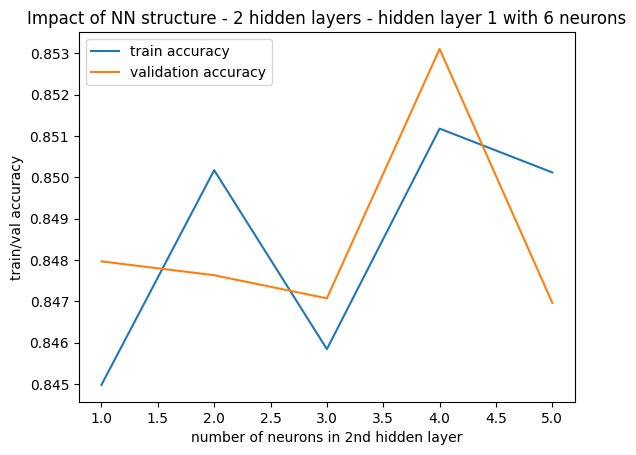

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[5,:], label = 'train accuracy')
plt.plot(idx, resval[5,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 6 neurons')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 7 neurons')

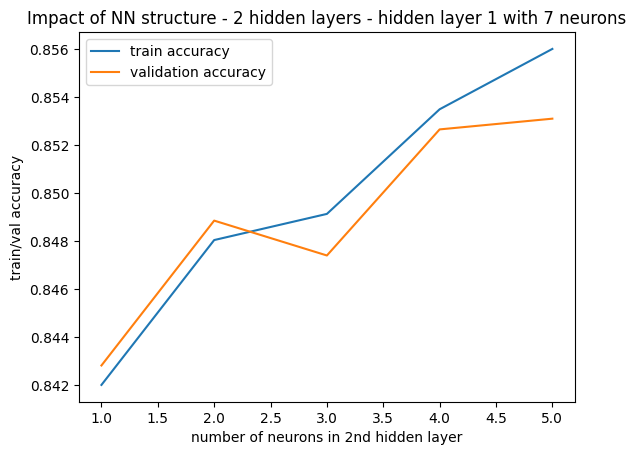

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[6,:], label = 'train accuracy')
plt.plot(idx, resval[6,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 7 neurons')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 9 neurons')

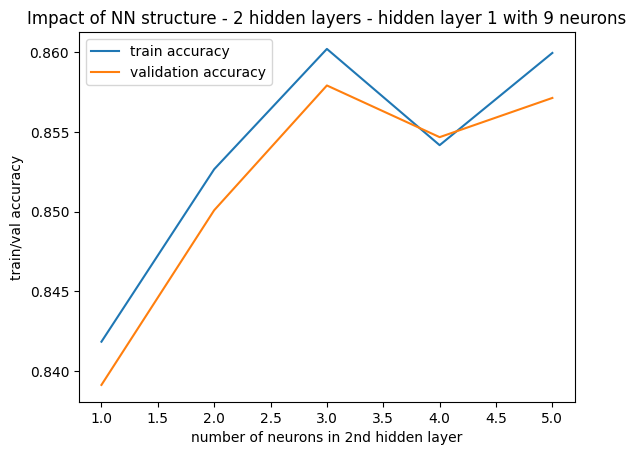

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[8,:], label = 'train accuracy')
plt.plot(idx, resval[8,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 9 neurons')

Text(0.5, 1.0, 'Impact of NN structure - 2 hidden layers - hidden layer 1 with 10 neurons')

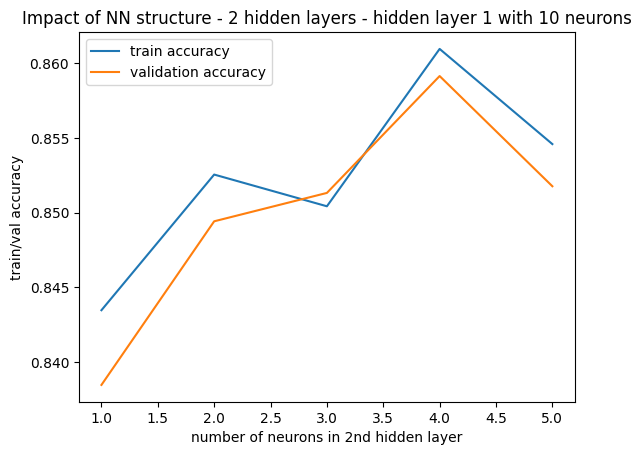

In [ ]:

idx = np.arange(5)+1
plt.plot(idx, restrain[9,:], label = 'train accuracy')
plt.plot(idx, resval[9,:], label = 'validation accuracy')
plt.legend()
plt.xlabel('number of neurons in 2nd hidden layer')
plt.ylabel('train/val accuracy')
plt.title('Impact of NN structure - 2 hidden layers - hidden layer 1 with 10 neurons')

Tester le NN 2 layers avec le meilleur compromis simplicité /précision : on retient 7 neurones dans la permiere couche cachée et 5 neurones dans la deuxieme couche cachée.

In [ ]:
# test d'un NN 2 couches (7, 5)
model = MLPClassifier(solver='adam', alpha=0.1, hidden_layer_sizes=(7, 5), max_iter = 10000, random_state=42)
model.fit(Xtrain, y_train)
predtrain = model.predict(Xtrain)
accuracytrain=np.mean(y_train==predtrain)
#print("Accuracy of the training dataset : ", accuracytrain )
predval=model.predict(Xval)
accuracyval=np.mean(y_val==predval)
#print("Accuracy of the validation dataset : ", accuracyval )
print_results(predtrain, y_train, accuracytrain, predval, y_val, accuracyval)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      85.60        94.90        46.18        52.61

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    85.31      94.96      45.97      51.16


In [ ]:
#Predictions on test dataset
predtest = model.predict(Xtest)
u, c = np.unique(predtest, return_counts =True)
print(c)

[8981  293 1046]


In [ ]:
# test model on test set

export_output(predtest, 'results_NN2_7_5_reg0.1.csv') # test accuracy = 75.3

## III.3 - Modèle SVM avec noyau gaussien

In [ ]:
from sklearn.svm import SVC
clf = SVC( gamma='auto') #the default kernel in scikitlearn SVC is the gaussian kernel

In [ ]:
clf.fit(Xtrain, y_train)

SVC(gamma='auto')

In [ ]:
predtrain = clf.predict(Xtrain)
predval = clf.predict(Xval)
acctrain = np.mean(predtrain==y_train)
accval = np.mean(predval==y_val)

print_results(predtrain, y_train,acctrain, predval, y_val, accval)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      87.47        96.62        49.90        54.73

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    87.20      96.64      50.81      53.28


In [ ]:
#predictions on test dataset
predtest = model.predict(Xtest)
u, c = np.unique(predtest, return_counts =True)
print(c)

[8981  293 1046]


In [ ]:
# test model on test set

export_output(predtest, 'results_SVM_RBF.csv') # test accuracy = 74.2

In [ ]:
#Adding weights to rebalance training data
clf2 = SVC( gamma='auto', class_weight ={0: 1, 1: 2, 2: 2} )

In [ ]:
clf2.fit(Xtrain, y_train)

SVC(class_weight={0: 1, 1: 2, 2: 2}, gamma='auto')

In [ ]:
predtrain = clf2.predict(Xtrain)
predval = clf2.predict(Xval)
acctrain = np.mean(predtrain==y_train)
accval = np.mean(predval==y_val)

print_results(predtrain, y_train,acctrain, predval, y_val, accval)

                acc_train  acc_train_0  acc_train_1  acc_train_2
train accuracy      87.51        90.57        65.59        78.76

               acc_val  acc_val_0  acc_val_1  acc_val_2
val accuracy    87.47      90.80      66.13      77.51


In [ ]:
# test model on test set
predtest = clf2.predict(Xtest)
export_output(predtest, 'results_SVM_weights2_2.csv') # test accuracy = 73.9

# Annexe 1 - Analyse des données ClimateNet

Les cellules ci-dessous permettent d'analyser quelques statistiques sur les données d'entrainement.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [ ]:
# functions to prepare features data - output data
#normalization
def normalize(X):
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    return (X-mu)/std
#add column of ones (bias term)
def add_bias(X):
    return np.c_[np.ones(X.shape[0]), X]

#one hot encoding
def Onehot(Y):
    return np.eye(np.int32(Y.max()+1))[np.int32(Y)]


In [ ]:
#Training set
#load data in pd
df = pd.read_csv('train.csv')
dt = pd.read_csv('test.csv')
print(list(df))

['SNo', 'lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'time', 'Label']


In [ ]:
#Training set
#convert 'time' into Year|Month|day

df['time']= pd.to_datetime(df['time'], format='%Y%m%d')
df['year'] = pd.DatetimeIndex(df['time']).year
df['month'] = pd.DatetimeIndex(df['time']).month
df['day'] = pd.DatetimeIndex(df['time']).day

#Test set
#convert 'time' into Year|Month|day

dt['time']= pd.to_datetime(dt['time'], format='%Y%m%d')
dt['year'] = pd.DatetimeIndex(dt['time']).year
dt['month'] = pd.DatetimeIndex(dt['time']).month
dt['day'] = pd.DatetimeIndex(dt['time']).day



In [ ]:
# split features and labels
features = ['TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT']
dx = df[features]
dy = df['Label']
dtest = dt[features]
print(np.array(dx)[np.where(dy==0)].shape, dy.shape)

(35179, 16) (44760,)


In [ ]:
#Proportion of labels in training set:
classes, counts = np.unique(dy, return_counts=True)
print('Label 0: Background\n', np.round(counts[0]/counts.sum(),3))
print('Label 1: Tropical Cyclone\n', np.round(counts[1]/counts.sum(),3))
print('Label 2: Atmospheric River\n', np.round(counts[2]/counts.sum(),3))

Label 0: Background
 0.786
Label 1: Tropical Cyclone
 0.041
Label 2: Atmospheric River
 0.173


In [ ]:
#corrélations

pd.options.display.float_format = '{:.0f}'.format
stat1 = pd.DataFrame(np.corrcoef(dx,rowvar=False),index = dx.columns)
stat1.columns= dx.columns
print(stat1*100)


        TMQ  U850  V850  UBOT  VBOT  QREFHT  PS  PSL  T200  T500  PRECT  TS  \
TMQ     100   -16     4    -1    -4      89 -70  -70    37    66     25  75   
U850    -16   100    -9    85    -4     -29 -10  -10    -4   -25     -4 -37   
V850      4    -9   100   -13    74       1   3    4     5    -1     12   4   
UBOT     -1    85   -13   100   -12     -14 -25  -26     5    -9     -5 -23   
VBOT     -4    -4    74   -12   100      -7  15   15     0   -12      6  -2   
QREFHT   89   -29     1   -14    -7     100 -71  -70    38    74     16  88   
PS      -70   -10     3   -25    15     -71 100  100   -54   -67    -20 -64   
PSL     -70   -10     4   -26    15     -70 100  100   -54   -67    -20 -64   
T200     37    -4     5     5     0      38 -54  -54   100    38     11  37   
T500     66   -25    -1    -9   -12      74 -67  -67    38   100      8  77   
PRECT    25    -4    12    -5     6      16 -20  -20    11     8    100   9   
TS       75   -37     4   -23    -2      88 -64  -64

Moyennes et écarts types des features

In [ ]:
index = ['Mean', 'Std']
stats = pd.DataFrame([np.mean(dx, axis=0),np.std(dx, axis=0)], index = index).T
print(stats)


                  Mean          Std
TMQ        34.62197960  12.76582978
U850       -0.60981800   6.86631440
V850       -0.01727100   4.30715803
UBOT       -2.13879709   6.05911239
VBOT       -0.80801310   4.78687932
QREFHT      0.01437521   0.00395078
PS     101553.67651043 544.61321672
PSL    101555.96729375 543.66683501
T200      216.82933540   2.29581407
T500      264.35584376   3.46302452
PRECT       0.00000005   0.00000024
TS        298.34465158   3.76322625
TREFHT    296.92356950   3.99882973
Z1000     135.52165123  42.35535118
Z200    12290.11866850 129.30988804
ZBOT       65.38447430   1.03576530


Moyennes par classes:

In [ ]:
print(pd.DataFrame([np.mean(dx[dy==0], axis=0), np.mean(dx[dy==1], axis=0),np.mean(dx[dy==2], axis=0)]).T)

                     0               1               2
TMQ        34.62704442     52.88343531     30.30205543
U850       -1.64843427     -1.02042799      4.19766588
V850        0.00593276      2.01965898     -0.60180969
UBOT       -2.86162513     -0.08366974      0.65616939
VBOT       -0.94514463      0.72268344     -0.54619916
QREFHT      0.01461903      0.01864702      0.01226411
PS     101563.38533148 100696.23107990 101711.39844122
PSL    101566.07057875 100698.07266371 101712.00574616
T200      216.84761358    219.22203929    216.18342347
T500      264.56460369    267.78002023    262.60325383
PRECT       0.00000004      0.00000021      0.00000004
TS        298.76674485    301.28627329    295.73798851
TREFHT    297.28419238    300.31032835    294.49097704
Z1000     135.82480684     78.57759246    147.54565797
Z200    12300.72543848  12402.47120733  12215.57264677
ZBOT       65.47257157     66.30000825     64.76946356


Écarts-types par classes:

In [ ]:
print(pd.DataFrame([np.std(dx[dy==0], axis=0), np.std(dx[dy==1], axis=0),np.std(dx[dy==2], axis=0)]).T)

                  0            1            2
TMQ     12.71765464   7.37397825   9.84662035
U850     5.82032873  11.21201775   7.79775833
V850     3.67341047   9.31403823   4.91160042
UBOT     5.34778153  10.51507929   6.70540980
VBOT     4.19901833   7.55220080   6.17575290
QREFHT   0.00401516   0.00172274   0.00269015
PS     530.70683308 478.95056271 426.54876149
PSL    529.62776090 478.55440548 426.13435122
T200     2.23048985   1.50094851   2.35715151
T500     3.35897064   1.37125593   3.40051550
PRECT    0.00000012   0.00000103   0.00000014
TS       3.66995295   1.79581199   3.20018019
TREFHT   4.01241058   1.59043094   3.07543149
Z1000   42.72178258  15.19409861  33.35250928
Z200   125.46421365  37.92930674 125.39294576
ZBOT     1.04490684   0.38893141   0.76987502


Text(0.5, 1.0, 'Scatter plot of training data labels by Geographical positions')

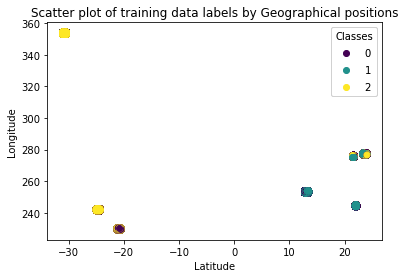

In [ ]:
#Analyse frequency of extreme weather events by Geographical position and time

colors = df['Label']
#for i in range(dataX.shape[1]-1):

fig, ax = plt.subplots()

scatter = ax.scatter(x = df['lat'], y = df['lon'], c = colors  )
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Scatter plot of training data labels by Geographical positions")


In [ ]:
#Analyse frequency of extreme weather events by Geographical position and time
# Define 6 geographical zones
#1 to 6
zones = np.array([[-30,350],[-25,245],[-22,230],[13,258],[22,245],[25,280]])
index = np.arange(6)+1
heads = ['Lat', 'Lon']
z = pd.DataFrame(zones,index = index)
z.columns = heads
z.index.name = 'Zones'

print(z)
# function that allocates a position (Lat, Lon) to the nearest geographical zone|replaces Lat Lon by geographical zone 1 to 6
def ZoneGeo(X):
    zoneX = np.zeros((X.shape[0],zones.shape[0]))
    for i in range(zones.shape[0]):
        zoneX[:,i] = np.linalg.norm(X[:,0:2] - zones[i,:], axis = 1)
    X[:,1] = np.argmin(zoneX, axis=1)
    X = X[:,1:]
    return X


       Lat  Lon
Zones          
1      -30  350
2      -25  245
3      -22  230
4       13  258
5       22  245
6       25  280


In [ ]:
#extract geographic positions and time from input data
features = ['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT', 'year', 'month', 'day']
dfx = df[features]
dfy = df['Label']
dx = np.copy(np.array(dfx))
dy = np.copy(np.array(dfy))

d_geo = ZoneGeo(dx)

print(dfx.shape, dfy.shape, d_geo.shape)




(44760, 21) (44760,) (44760, 20)


In [ ]:
print(d_geo[:2])

[[ 5.00000000e+00  7.89094315e+01 -5.88052292e+01  3.62006722e+01
  -5.82604752e+01 -7.22955108e-01  2.23211930e-02  9.74977969e+04
   9.74989062e+04  2.27119232e+02  2.73045563e+02  1.39000000e-05
   3.02350861e+02  3.00026764e+02  6.63398361e+01  1.24002275e+04
   6.62415848e+01  2.00300000e+03  1.00000000e+01  2.40000000e+01]
 [ 5.00000000e+00  7.89094315e+01 -5.88052292e+01  3.62006722e+01
  -5.82604752e+01 -7.22955108e-01  2.23211930e-02  9.74977969e+04
   9.74989062e+04  2.27119232e+02  2.73045563e+02  1.39000000e-05
   3.02350861e+02  3.00026764e+02  6.63398361e+01  1.24002275e+04
   6.62415848e+01  2.00300000e+03  1.00000000e+01  2.40000000e+01]]


In [ ]:
#frequency of extreme weather events by geo zones and time
freq_0 = np.zeros((zones.shape[0],12))
freq_1 = np.zeros((zones.shape[0],12))
freq_2 = np.zeros((zones.shape[0],12))

for m in range(12):
    for z in range(zones.shape[0]):
        classes, c = np.unique(dy[np.where((d_geo[:,0]==z) &(d_geo[:,-2]==m+1))],return_counts= True)
 #       print(classes.shape, c.shape)
        if classes.shape[0] == 1:
            freq_0[z,m] = c[classes[0]]/c.sum()

        if classes.shape[0]==2:
            if classes[0] == 0:
                freq_0[z,m] = c[0]/c.sum()
            if classes[0] == 1:
                freq_1[z,m] = c[0]/c.sum()
            if classes[0] == 2:
                freq_2[z,m] = c[0]/c.sum()
            if classes[1] == 0:
                freq_0[z,m] = c[1]/c.sum()
            if classes[1] == 1:
                freq_1[z,m] = c[1]/c.sum()
            if classes[1] == 2:
                freq_2[z,m] = c[1]/c.sum()
        if classes.shape[0]==3:
            freq_0[z,m] = c[0]/c.sum()
            freq_1[z,m] = c[1]/c.sum()
            freq_2[z,m] = c[2]/c.sum()


In [ ]:

# impression des frequences des CT et RA par zones geo et par mois
f1 = pd.DataFrame(freq_1, index = index)
f2 = pd.DataFrame(freq_2, index = index)
f1.columns= np.arange(12)+1
f1.index.names = ['Zones']
f2.columns= np.arange(12)+1
f2.index.names = ['Zones']
pd.options.display.float_format = '{:.1f}'.format

with np.printoptions(precision=2):
    print(f1*100)




       1   2   3   4   5    6    7    8    9    10   11   12
Zones                                                       
1     0.0 0.0 0.0 0.0 0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0
2     0.0 0.0 0.0 0.0 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0 0.0 0.0 0.0 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.0 0.0 0.0 0.0 0.0 10.2 20.7 14.1 12.0 18.5 15.2 28.0
5     0.0 0.0 0.0 0.0 0.0  2.0 13.8 28.7 14.3  5.1  0.0  0.0
6     0.0 0.0 0.0 0.0 0.0  2.0  4.4  0.0  1.7 17.1  0.7  0.0
        1    2    3    4    5    6    7    8    9    10   11   12
Zones                                                            
1      0.0 35.5 27.8 21.4  0.0 38.6 23.7 42.9 44.1 37.7 40.2 40.4
2      0.0 27.3  9.2 78.2 50.0 40.2 37.5 32.7 30.4 35.7 32.0  0.4
3      0.0  3.6  0.0 30.7 33.3 34.2 24.3 42.2 43.0 38.3 20.0  4.0
4      0.0  0.0  0.0  0.0  0.0  0.0  1.7  3.5  0.0  0.0  0.0  0.0
5      0.0  0.0  0.0  0.0  0.0  0.0  1.7  1.6  0.0  2.0  0.0  0.0
6     21.2 19.1  0.0  0.0  0.0  4.1  0.6  0.0  0.0

In [ ]:
# frequences des RA
print(f2*100)

        1    2    3    4    5    6    7    8    9    10   11   12
Zones                                                            
1      0.0 35.5 27.8 21.4  0.0 38.6 23.7 42.9 44.1 37.7 40.2 40.4
2      0.0 27.3  9.2 78.2 50.0 40.2 37.5 32.7 30.4 35.7 32.0  0.4
3      0.0  3.6  0.0 30.7 33.3 34.2 24.3 42.2 43.0 38.3 20.0  4.0
4      0.0  0.0  0.0  0.0  0.0  0.0  1.7  3.5  0.0  0.0  0.0  0.0
5      0.0  0.0  0.0  0.0  0.0  0.0  1.7  1.6  0.0  2.0  0.0  0.0
6     21.2 19.1  0.0  0.0  0.0  4.1  0.6  0.0  0.0  5.2  4.0 19.9
